In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import pcmdpy as ppy
from tqdm import tqdm
%matplotlib inline

GPU acceleration enabled
using given n: 0
Starting SourceModule Code
Past the SourceModule code
CUDAC Available


In [2]:
ppy.__version__

'0.4.5b'

In [3]:
plt.style.use('seaborn-poster')
mpl.rcParams['image.origin'] = 'lower'

In [4]:
f = ppy.instrument.default_m31_filters()
iso_model = ppy.isochrones.Isochrone_Model(f)

In [5]:
driv = ppy.driver.Driver(iso_model)

In [6]:
m31_bulge = np.loadtxt('../data/m31/m31_r1.pcmd', unpack=True)
m31_disk = np.loadtxt('../data/m31/m31_r2.pcmd', unpack=True)

OSError: ../data/m31/m31_r1.pcmd not found.

In [ ]:
np.sqrt(m31_bulge.shape[1])

In [ ]:
g = ppy.galaxy.CustomGalaxy(
    ppy.metalmodels.FixedWidthNormMDF(0.2), 
    ppy.dustmodels.SingleDust(),
    ppy.sfhmodels.TauModel(),
    ppy.distancemodels.VariableDistance()
)

In [8]:
res = {}
res['m31_bulge'] = ppy.plotting.ResultsPlotter('results/m31_tau_narrow_r1.csv', run_name='M31 Bulge')
res['m31_disk'] = ppy.plotting.ResultsPlotter('results/m31_tau_narrow_r2.csv', run_name='M31 Disk')
res['m31_bulge_psf'] = ppy.plotting.ResultsPlotter('results/m31_tau_narrowF814W_r1.csv', run_name='M31 Bulge (Narrow F814W)')
res['m31_disk_psf'] = ppy.plotting.ResultsPlotter('results/m31_tau_narrowF814W_r2.csv', run_name='M31 Disk (Narrow F814W)')

dmod_m31 = 24.42
xmax = np.max([len(r.df) for r in res.values()])
print(xmax)
for k, v in res.items():
    if '_nm' in k:
        v.df['dmod'] = dmod_m31

10559


In [9]:
def plot_sets(run_names, regions=[1,2], chains_only=False, dmod_true=24.42, nonparam=False):
    if chains_only:
        nr = 5
    else:
        nr = 8
    if nonparam:
        nr += 4
    nx = len(run_names)
    fs = (10+5*nx, 3*nr)
    fig, axes = plt.subplots(ncols=len(run_names)*len(regions), nrows=nr, figsize=fs, sharex=True, sharey='row')
    for i, r in enumerate(regions):
        for j, n in enumerate(run_names):
            plot_axes = axes[:, nx*i + j]
            if '_nm' in n:
                if nonparam:
                    plot_axes = list(plot_axes[:7])+list(plot_axes[8:])
                else:
                    plot_axes = list(plot_axes[:3])+list(plot_axes[4:])
            res[n.format(r)].plot_chains(axes=plot_axes, chains_only=chains_only)
    if not nonparam:
        for ax in axes[3]:
            ax.axhline(y=dmod_true, ls='--', color='r')
    plt.tight_layout()
    return fig, axes

In [10]:
def get_best_model(run_name):
    p = res[run_name].df.tail(1)[['logfeh_mean', 'logdust', 'logNpix', 'tau', 'dmod']].values[0]
    g.set_params(p)
    return g

In [11]:
res['m31_disk_psf'].df.logl.tail()

10054   -17461.0
10055   -17460.0
10056   -17460.0
10057   -17460.0
10058   -17460.0
Name: logl, dtype: float64

In [12]:
res['m31_disk'].df.logl.tail()

9514   -8444.9
9515   -8444.9
9516   -8444.6
9517   -8444.6
9518   -8444.4
Name: logl, dtype: float64

In [13]:
bins = [np.arange(22, 29, 0.05), np.arange(-1, 3.5, 0.05)]

In [17]:
mock_pcmds = {}
for k in tqdm(res.keys()):
    g = get_best_model(k)
    if 'psf' in k:
        driv.filters = ppy.instrument.m31_narrow_psf(F475W=False)
    else:
        driv.filters = ppy.instrument.default_m31_filters()
    mock_pcmds[k] = driv.simulate(g, 1024, fixed_seed=True, mag_system='ab')[0]

100%|██████████| 4/4 [00:25<00:00,  6.27s/it]


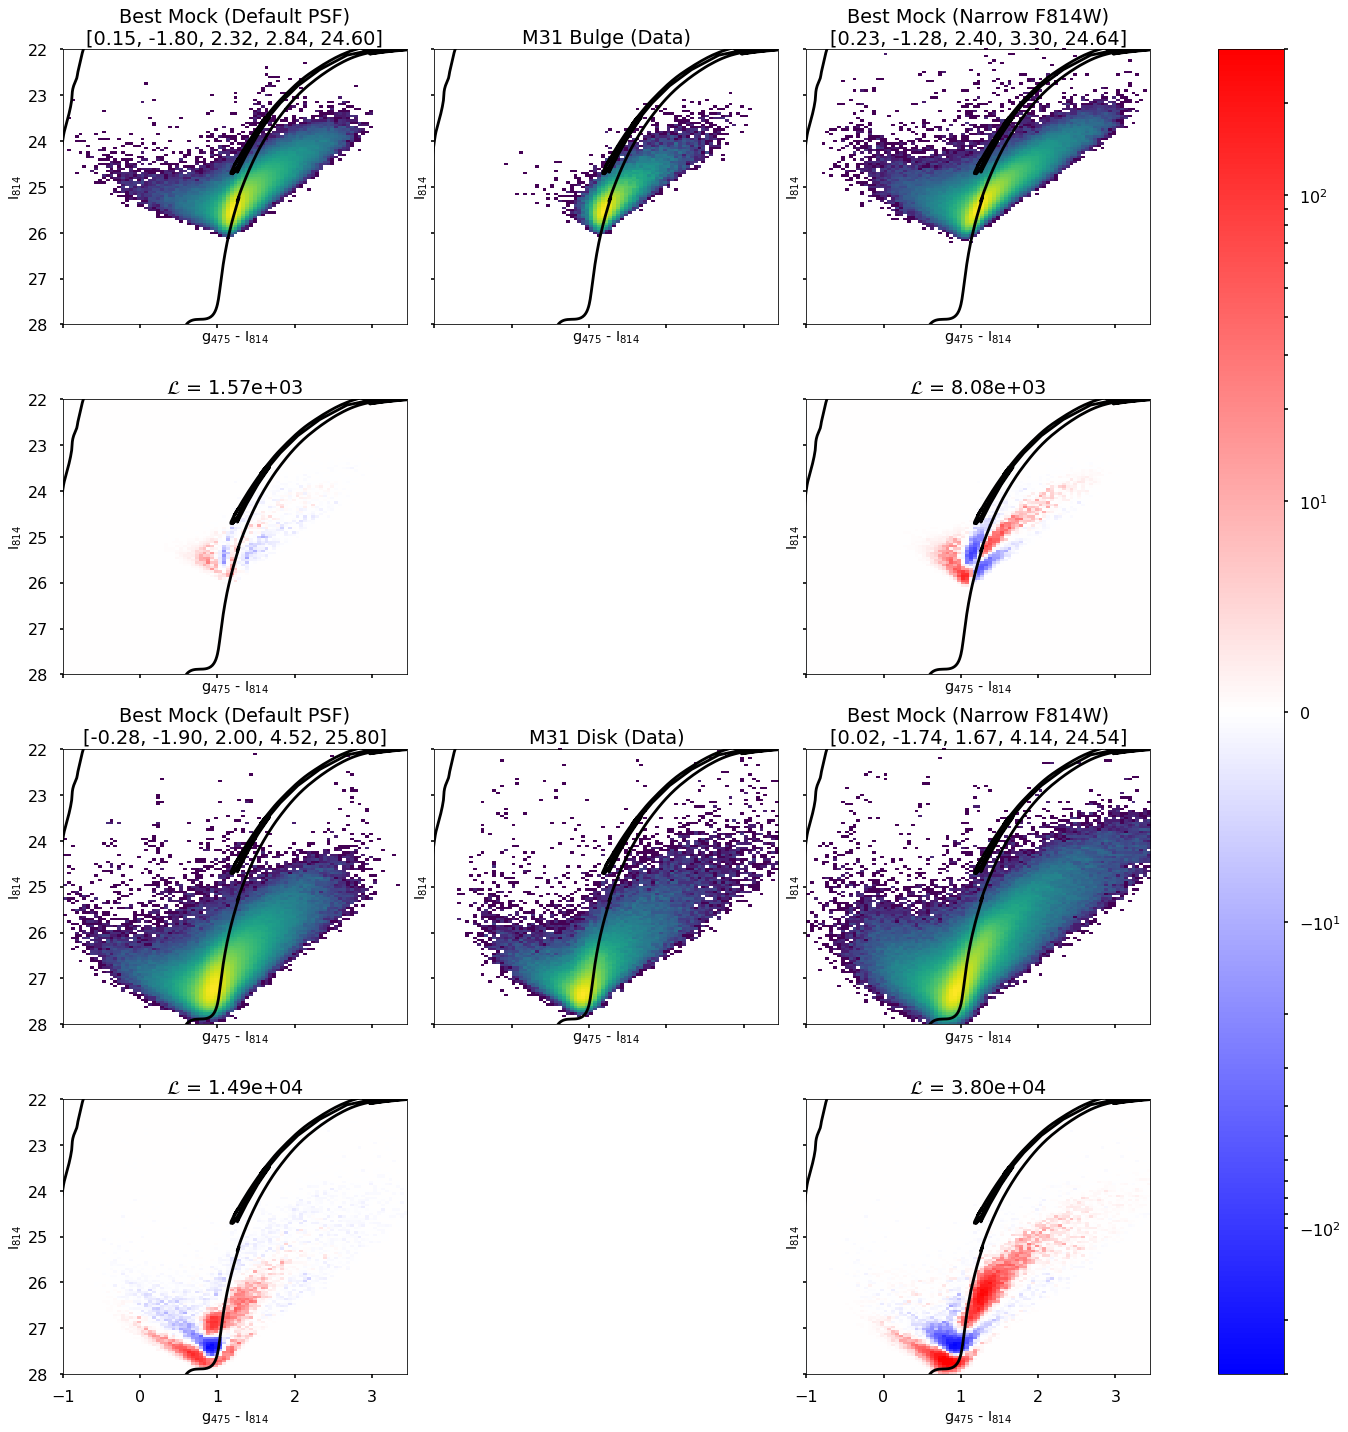

In [18]:
lm = 2
vm = 300
fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(20, 20), sharex=True, sharey=True)


a, k = axes[0,0], 'm31_bulge'
ppy.plotting.plot_pcmd(mock_pcmds[k], axes=a, bins=bins)
g = get_best_model(k)
a.set_title('Best Mock (Default PSF)\n[{:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}]'.format(*g._params))

ppy.plotting.plot_pcmd(m31_bulge, axes=axes[0,1], bins=bins, )
axes[0,1].set_title('M31 Bulge (Data)')

a, k = axes[0,2], 'm31_bulge_psf'
ppy.plotting.plot_pcmd(mock_pcmds[k], axes=a, bins=bins)
g = get_best_model(k)
a.set_title('Best Mock (Narrow F814W)\n[{:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}]'.format(*g._params))

driv.initialize_data(m31_bulge, bins=bins)

loglike = driv.loglike_map(mock_pcmds['m31_bulge'], like_mode=lm)[0]
# vm_t = np.max(np.abs(loglike))
# if vm_t > vm:
#     vm = vm_t
plt.subplot(axes[1,0])
plt.imshow(loglike, extent=[bins[1][0], bins[1][-1], bins[0][0], bins[0][-1]], aspect='auto', norm=mpl.colors.SymLogNorm(10., vmin=-vm, vmax=vm), cmap='bwr')
axes[1,0].set_title(r'$\mathcal{L}$' + ' = {:.2e}'.format(np.sum(np.abs(loglike))))

axes[1,1].axis('off')

loglike = driv.loglike_map(mock_pcmds['m31_bulge_psf'], like_mode=lm)[0]
# vm = np.max(np.abs(loglike))
# if vm_t > vm:
#     vm = vm_t
plt.subplot(axes[1,2])
plt.imshow(loglike, extent=[bins[1][0], bins[1][-1], bins[0][0], bins[0][-1]], aspect='auto', norm=mpl.colors.SymLogNorm(10., vmin=-vm, vmax=vm), cmap='bwr')
axes[1,2].set_title(r'$\mathcal{L}$' + ' = {:.2e}'.format(np.sum(np.abs(loglike))))


#=============================

a, k = axes[2,0], 'm31_disk'
ppy.plotting.plot_pcmd(mock_pcmds[k], axes=a, bins=bins)
g = get_best_model(k)
a.set_title('Best Mock (Default PSF)\n[{:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}]'.format(*g._params))

ppy.plotting.plot_pcmd(m31_disk, axes=axes[2,1], bins=bins, )
axes[2,1].set_title('M31 Disk (Data)')

a, k = axes[2,2], 'm31_disk_psf'
ppy.plotting.plot_pcmd(mock_pcmds[k], axes=a, bins=bins)
g = get_best_model(k)
a.set_title('Best Mock (Narrow F814W)\n[{:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}]'.format(*g._params))

driv.initialize_data(m31_disk, bins=bins)

loglike = driv.loglike_map(mock_pcmds['m31_disk'], like_mode=lm)[0]
# vm = np.max(np.abs(loglike))
# if vm_t > vm:
#     vm = vm_t
plt.subplot(axes[3,0])
plt.imshow(loglike, extent=[bins[1][0], bins[1][-1], bins[0][0], bins[0][-1]], aspect='auto', norm=mpl.colors.SymLogNorm(10., vmin=-vm, vmax=vm), cmap='bwr')
axes[3,0].set_title(r'$\mathcal{L}$' + ' = {:.2e}'.format(np.sum(np.abs(loglike))))

axes[3,1].axis('off')

loglike = driv.loglike_map(mock_pcmds['m31_disk_psf'], like_mode=lm)[0]
# vm = np.max(np.abs(loglike))
# if vm_t > vm:
#     vm = vm_t
plt.subplot(axes[3,2])
plt.imshow(loglike, extent=[bins[1][0], bins[1][-1], bins[0][0], bins[0][-1]], aspect='auto', norm=mpl.colors.SymLogNorm(10., vmin=-vm, vmax=vm), cmap='bwr')
axes[3,2].set_title(r'$\mathcal{L}$' + ' = {:.2e}'.format(np.sum(np.abs(loglike))))

for i, a in enumerate(axes.flatten()):
    if i not in [4, 10]:
        ppy.plotting.plot_isochrone(iso_model, dmod=dmod_m31, mag_system='ab', axes=a, zorder=1)

axes[0,0].set_ylim([28, 22])
plt.tight_layout()
plt.colorbar(ax=axes)
plt.savefig('figures/m31_mocks_psf_oldlike.jpg')

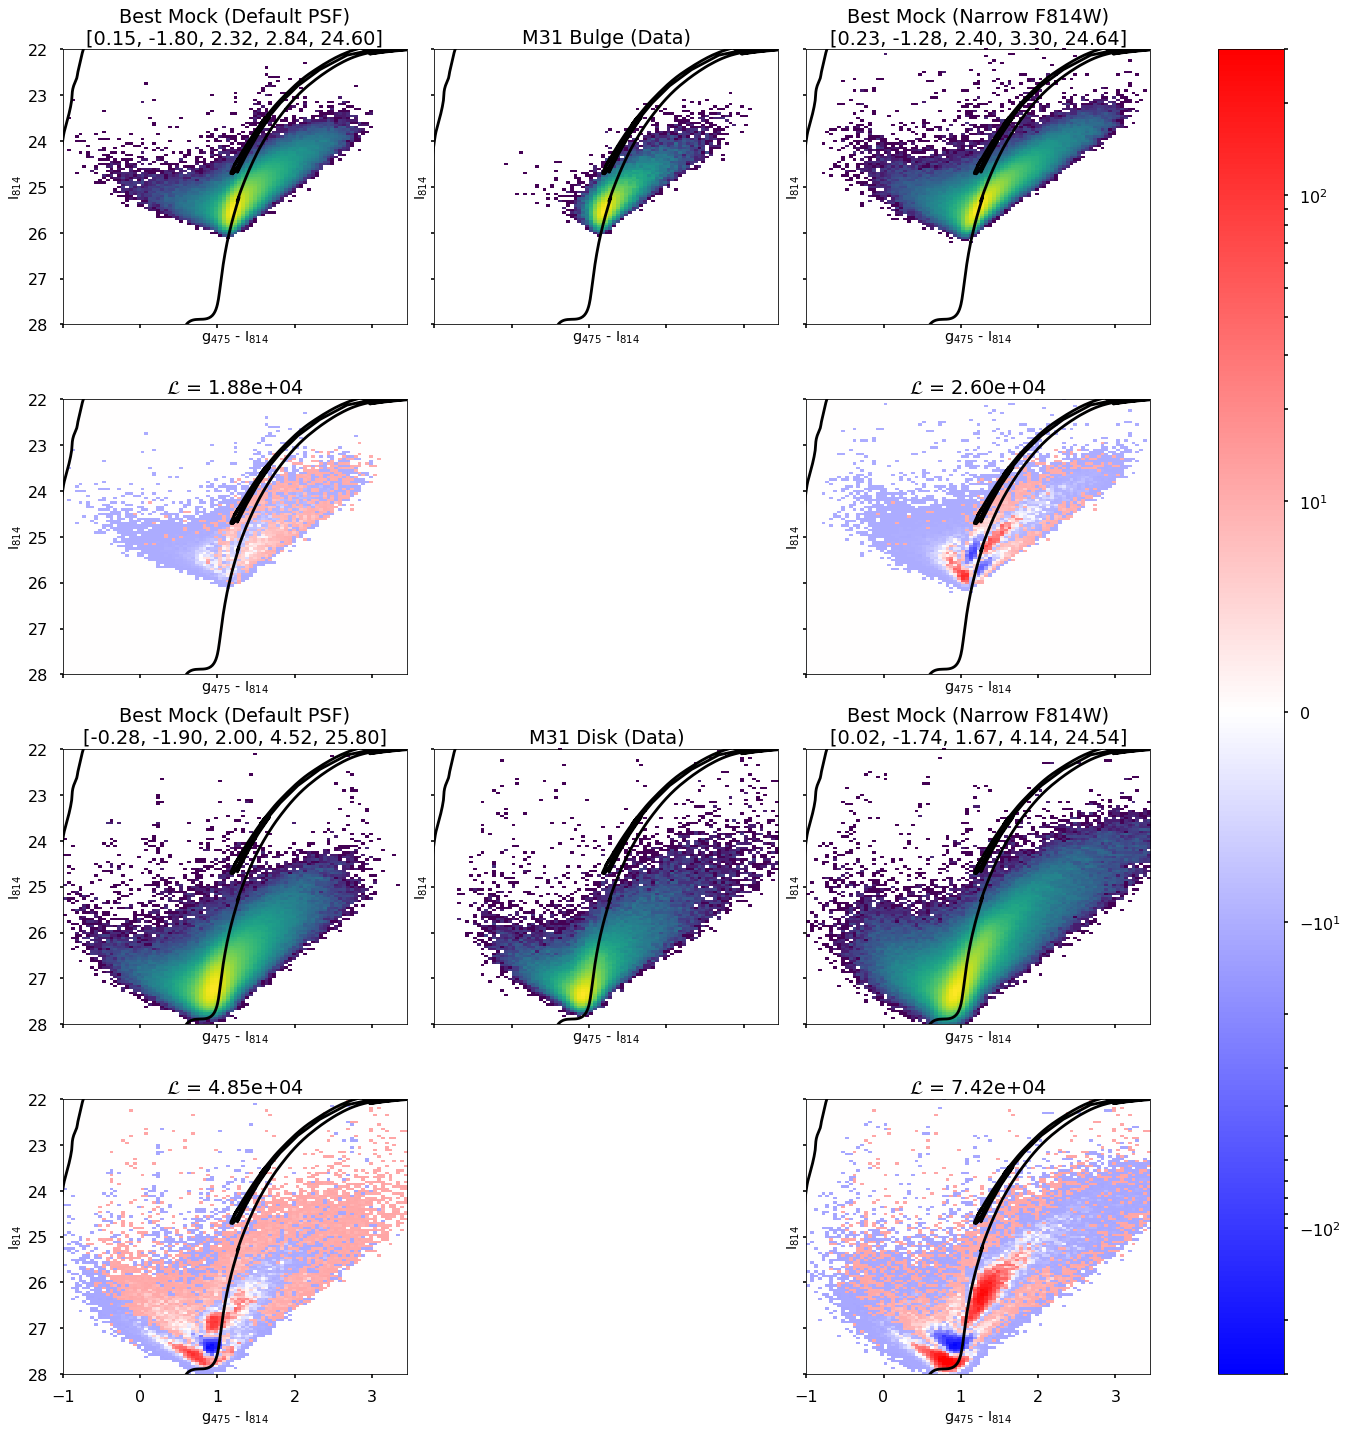

In [19]:
lm = 3
vm = 3e2
fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(20, 20), sharex=True, sharey=True)


a, k = axes[0,0], 'm31_bulge'
ppy.plotting.plot_pcmd(mock_pcmds[k], axes=a, bins=bins)
g = get_best_model(k)
a.set_title('Best Mock (Default PSF)\n[{:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}]'.format(*g._params))

ppy.plotting.plot_pcmd(m31_bulge, axes=axes[0,1], bins=bins, )
axes[0,1].set_title('M31 Bulge (Data)')

a, k = axes[0,2], 'm31_bulge_psf'
ppy.plotting.plot_pcmd(mock_pcmds[k], axes=a, bins=bins)
g = get_best_model(k)
a.set_title('Best Mock (Narrow F814W)\n[{:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}]'.format(*g._params))

driv.initialize_data(m31_bulge, bins=bins)

loglike = driv.loglike_map(mock_pcmds['m31_bulge'], like_mode=lm)[0]
# vm_t = np.max(np.abs(loglike))
# if vm_t > vm:
#     vm = vm_t
plt.subplot(axes[1,0])
plt.imshow(loglike, extent=[bins[1][0], bins[1][-1], bins[0][0], bins[0][-1]], aspect='auto', norm=mpl.colors.SymLogNorm(10., vmin=-vm, vmax=vm), cmap='bwr')
axes[1,0].set_title(r'$\mathcal{L}$' + ' = {:.2e}'.format(np.sum(np.abs(loglike))))

axes[1,1].axis('off')

loglike = driv.loglike_map(mock_pcmds['m31_bulge_psf'], like_mode=lm)[0]
# vm = np.max(np.abs(loglike))
# if vm_t > vm:
#     vm = vm_t
plt.subplot(axes[1,2])
plt.imshow(loglike, extent=[bins[1][0], bins[1][-1], bins[0][0], bins[0][-1]], aspect='auto', norm=mpl.colors.SymLogNorm(10., vmin=-vm, vmax=vm), cmap='bwr')
axes[1,2].set_title(r'$\mathcal{L}$' + ' = {:.2e}'.format(np.sum(np.abs(loglike))))


#=============================

a, k = axes[2,0], 'm31_disk'
ppy.plotting.plot_pcmd(mock_pcmds[k], axes=a, bins=bins)
g = get_best_model(k)
a.set_title('Best Mock (Default PSF)\n[{:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}]'.format(*g._params))

ppy.plotting.plot_pcmd(m31_disk, axes=axes[2,1], bins=bins, )
axes[2,1].set_title('M31 Disk (Data)')

a, k = axes[2,2], 'm31_disk_psf'
ppy.plotting.plot_pcmd(mock_pcmds[k], axes=a, bins=bins)
g = get_best_model(k)
a.set_title('Best Mock (Narrow F814W)\n[{:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}]'.format(*g._params))

driv.initialize_data(m31_disk, bins=bins)

loglike = driv.loglike_map(mock_pcmds['m31_disk'], like_mode=lm)[0]
# vm = np.max(np.abs(loglike))
# if vm_t > vm:
#     vm = vm_t
plt.subplot(axes[3,0])
plt.imshow(loglike, extent=[bins[1][0], bins[1][-1], bins[0][0], bins[0][-1]], aspect='auto', norm=mpl.colors.SymLogNorm(10., vmin=-vm, vmax=vm), cmap='bwr')
axes[3,0].set_title(r'$\mathcal{L}$' + ' = {:.2e}'.format(np.sum(np.abs(loglike))))

axes[3,1].axis('off')

loglike = driv.loglike_map(mock_pcmds['m31_disk_psf'], like_mode=lm)[0]
# vm = np.max(np.abs(loglike))
# if vm_t > vm:
#     vm = vm_t
plt.subplot(axes[3,2])
plt.imshow(loglike, extent=[bins[1][0], bins[1][-1], bins[0][0], bins[0][-1]], aspect='auto', norm=mpl.colors.SymLogNorm(10., vmin=-vm, vmax=vm), cmap='bwr')
axes[3,2].set_title(r'$\mathcal{L}$' + ' = {:.2e}'.format(np.sum(np.abs(loglike))))

for i, a in enumerate(axes.flatten()):
    if i not in [4, 10]:
        ppy.plotting.plot_isochrone(iso_model, dmod=dmod_m31, mag_system='ab', axes=a, zorder=1)

axes[0,0].set_ylim([28, 22])
plt.tight_layout()
plt.colorbar(ax=axes)
plt.savefig('figures/m31_mocks_psf_newlike.jpg')

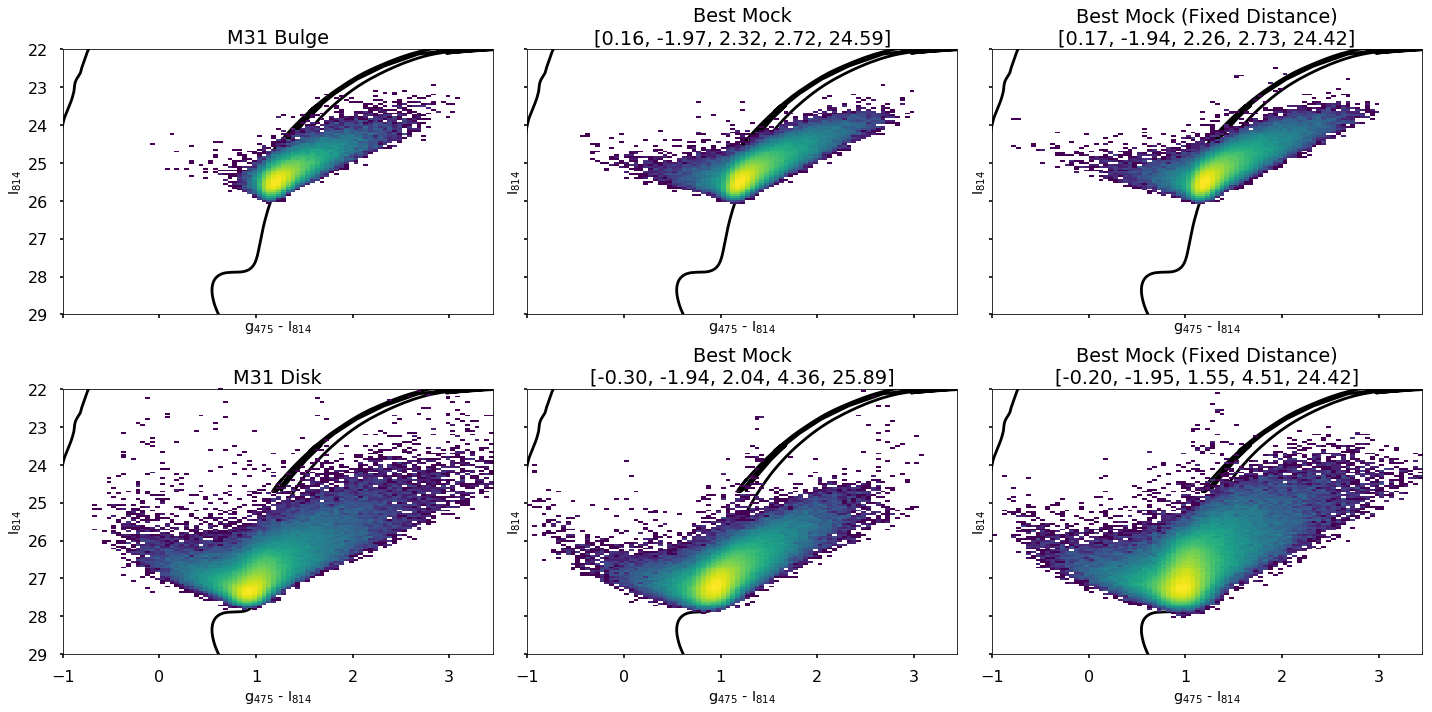

In [60]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(20, 10), sharex=True, sharey=True)

ppy.plotting.plot_pcmd(m31_bulge, axes=axes[0,0], bins=bins)
axes[0,0].set_title('M31 Bulge')

a, k = axes[0,1], 'm31_bulge'
ppy.plotting.plot_pcmd(mock_pcmds[k], axes=a, bins=bins)
g = get_best_model(k)
a.set_title('Best Mock\n[{:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}]'.format(*g._params))

a, k = axes[0,2], 'm31_bulge_nm'
ppy.plotting.plot_pcmd(mock_pcmds[k], axes=a, bins=bins)
g = get_best_model(k)
a.set_title('Best Mock (Fixed Distance)\n[{:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}]'.format(*g._params))

ppy.plotting.plot_pcmd(m31_disk, axes=axes[1,0], bins=bins)
axes[1,0].set_title('M31 Disk')

a, k = axes[1,1], 'm31_disk'
ppy.plotting.plot_pcmd(mock_pcmds[k], axes=a, bins=bins)
g = get_best_model(k)
a.set_title('Best Mock\n[{:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}]'.format(*g._params))

a, k = axes[1,2], 'm31_disk_nm'
ppy.plotting.plot_pcmd(mock_pcmds[k], axes=a, bins=bins)
g = get_best_model(k)
a.set_title('Best Mock (Fixed Distance)\n[{:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}]'.format(*g._params))


for a in axes.flatten():
    ppy.plotting.plot_isochrone(iso_model, dmod=dmod_m31, mag_system='ab', axes=a, zorder=-1)
    
axes[0,0].set_ylim([29, 22])
plt.tight_layout()

In [65]:
driv.filters[0]._psf.shape

(4, 4, 74, 74)

In [66]:
driv.filters = ppy.instrument.m31_narrow_psf()
g = get_best_model('m31_disk_nm')
mock_pcmds['m31_disk_narrow'] = driv.simulate(g, 512, fixed_seed=True, mag_system='ab')[0]

driv.filters = ppy.instrument.m31_narrow_psf(extra=True)
g = get_best_model('m31_disk_nm')
mock_pcmds['m31_disk_extra-narrow'] = driv.simulate(g, 512, fixed_seed=True, mag_system='ab')[0]

driv.filters = ppy.instrument.m31_narrow_psf(F475W=False)
g = get_best_model('m31_disk_nm')
mock_pcmds['m31_disk_single'] = driv.simulate(g, 512, fixed_seed=True, mag_system='ab')[0]

In [67]:
driv.filters = ppy.instrument.m31_narrow_psf()
g = get_best_model('m31_bulge_nm')
mock_pcmds['m31_bulge_narrow'] = driv.simulate(g, 512, fixed_seed=True, mag_system='ab')[0]

driv.filters = ppy.instrument.m31_narrow_psf(extra=True)
g = get_best_model('m31_bulge_nm')
mock_pcmds['m31_bulge_extra-narrow'] = driv.simulate(g, 512, fixed_seed=True, mag_system='ab')[0]

driv.filters = ppy.instrument.m31_narrow_psf(F475W=False)
g = get_best_model('m31_bulge_nm')
mock_pcmds['m31_bulge_single'] = driv.simulate(g, 512, fixed_seed=True, mag_system='ab')[0]

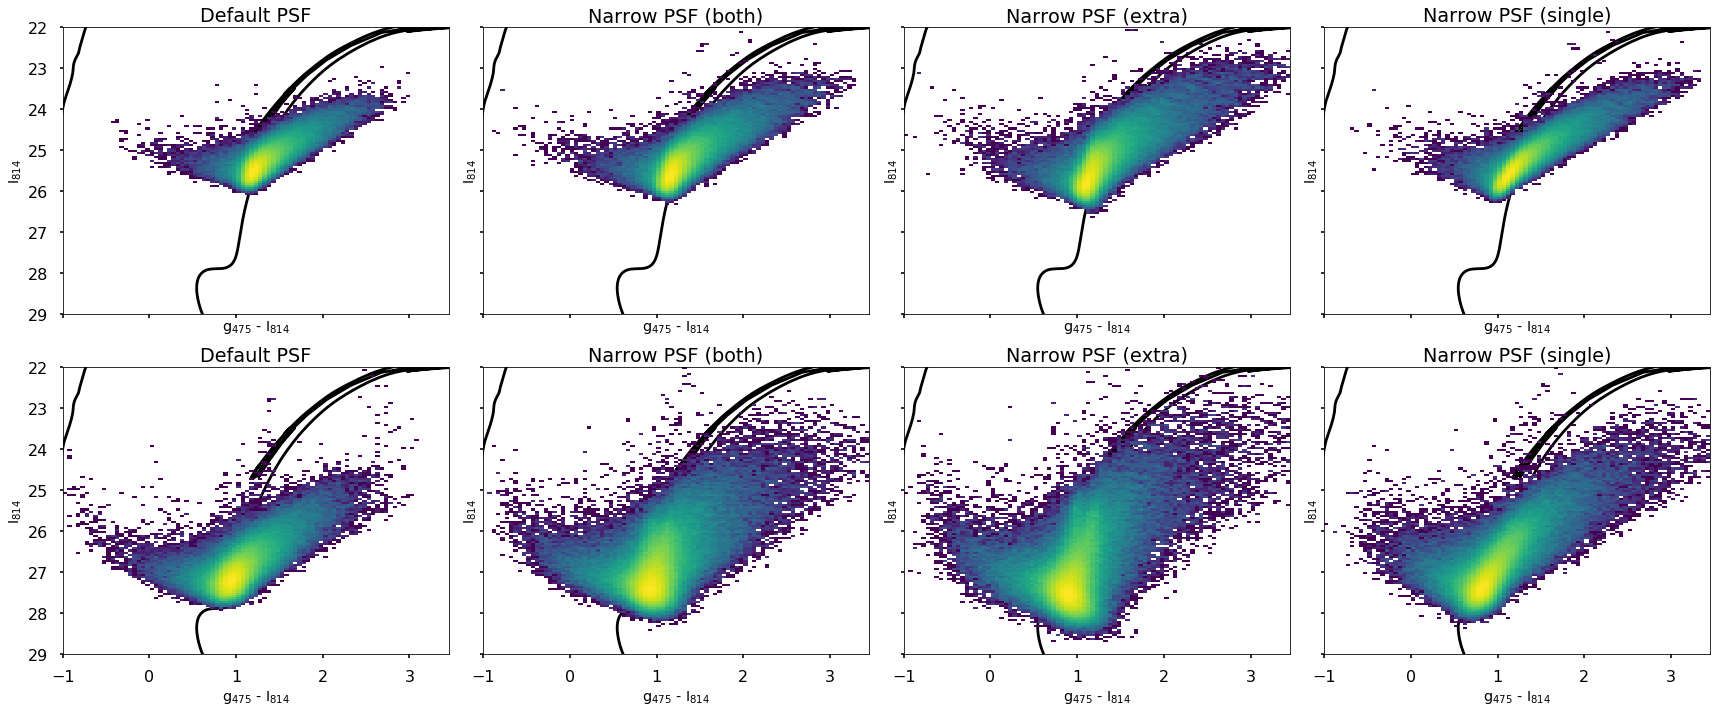

In [68]:
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(24, 10), sharex=True, sharey=True)

a, k = axes[0,0], 'm31_bulge'
ppy.plotting.plot_pcmd(mock_pcmds[k], axes=a, bins=bins)
a.set_title('Default PSF')

a, k = axes[0,1], 'm31_bulge_narrow'
ppy.plotting.plot_pcmd(mock_pcmds[k], axes=a, bins=bins)
a.set_title('Narrow PSF (both)')

a, k = axes[0,2], 'm31_bulge_extra-narrow'
ppy.plotting.plot_pcmd(mock_pcmds[k], axes=a, bins=bins)
a.set_title('Narrow PSF (extra)')

a, k = axes[0,3], 'm31_bulge_single'
ppy.plotting.plot_pcmd(mock_pcmds[k], axes=a, bins=bins)
a.set_title('Narrow PSF (single)')

a, k = axes[1,0], 'm31_disk'
ppy.plotting.plot_pcmd(mock_pcmds[k], axes=a, bins=bins)
a.set_title('Default PSF')

a, k = axes[1,1], 'm31_disk_narrow'
ppy.plotting.plot_pcmd(mock_pcmds[k], axes=a, bins=bins)
a.set_title('Narrow PSF (both)')

a, k = axes[1,2], 'm31_disk_extra-narrow'
ppy.plotting.plot_pcmd(mock_pcmds[k], axes=a, bins=bins)
a.set_title('Narrow PSF (extra)')

a, k = axes[1,3], 'm31_disk_single'
ppy.plotting.plot_pcmd(mock_pcmds[k], axes=a, bins=bins)
a.set_title('Narrow PSF (single)')

for a in axes.flatten():
    ppy.plotting.plot_isochrone(iso_model, dmod=dmod_m31, mag_system='ab', axes=a, zorder=-1)
    
axes[0,0].set_ylim([29, 22])
plt.tight_layout()